สามารถโหลด Dataset ที่ใช้ได้ที่ 
https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.backend import clear_session

In [3]:
clear_session()

### 1. Feature Extraction 
ใช้ Model VGG16 ในการทำ Feature Extraction โดยแยก Object Feature จากรูปภาพให้อยู่ในรูปแบบของ Vector

In [4]:
# load vgg16 model
model = VGG16(weights='imagenet')
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

ทำการใช้ Model ที่กำหนดมาทำนาย Predict หา feature vector จากรูปภาพ โดย Dataset ที่ใช้คือ flickr30k

In [6]:
# # extract features from image
# features = {}
# directory = 'Images30k'

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(299, 299))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

ทำการ Save file Feature Vector ที่ Extract ได้จากรูปภาพทั้งหมด ผ่านไฟล์ .pkl สำหรับใช้ภายในการเทรนโมเดล

In [7]:
#With Pretrained
filepath = os.path.join('Save', 'features_30k_pretrained.pkl')
#Without Pretrained
# filepath = os.path.join('Save', 'features_30k.pkl')

#store features in pickle
# pickle.dump(features, open(filepath, 'wb'))
# load features from pickle
with open(filepath, 'rb') as f:
    features = pickle.load(f)

In [8]:
with open("results.csv", 'r') as f:
    next(f)
    captions_doc = f.read()

### Preprocess

ทำการระบุ Caption จากภาพภายในไฟล์ .csv ไปยังรูปภาพทั้งหมด

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

ทำการ Preprocess Text โดยการเปลี่ยนตัวอักษรทุกตัวให้อยู่ในรูปแบบเดียวกัน (ตัวพิมพ์เล็ก) และลบตัวเลขหรือตัวอักษรพิเศษออก และเพิ่มตัวเปิดประโยคและตัวปิดประโยค เพื่อเป็นการบอกจุดเริ่มและจุดจบของ Sequence ประโยค

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

ทำ Tokenization เพื่อทำการแยกคำทั้งหมด และระบุขนาดจำนวนคำภายใน Vocab สำหรับใช้ภายใน embedding layer ต่อไป

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

### Data generation

แบ่งไฟล์ train และ test ออกเป็น อัตราส่วน 90:10 สำหรับการเทรน และ เทส โมเดล

In [13]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

เนื่องจากเราไม่สามารถนำข้อมูลรูปภาพทั้งหมดยัดลงไปภายในการเรียนรู้ของโมเดลได้เพียงครั้งเดียวเนื่องจากจะทำให้หน่วยความจำไม่เพียงพอเราจึงจำเป็นจะต้องแบ่งข้อมูลออกเป็น batch เพื่อลดจำนวนข้อมูล memory ที่จะต้องใช้ในการเทรนโมเดล

In [14]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model

In [15]:
clear_session()

In [16]:
# encoder model
# image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


กำหนด ฟังชันก์สำหรับการ Save weight และ load weight ของโมเดลสำหรับการเทรนภายหลังหรือต้องการใช้งานภายในอนาคต

In [17]:
def save_load_weigth(flag ,weights):
    if flag == "save":
        if weights == "InceptionV3":
            model.save_weights("InceptionV.h5")
        elif weights == "VGG16_imagenet":
            model.save_weights("imagenet.h5")
        elif weights == "VGG16":
            model.save_weights("before_eat.h5")
    elif flag == "load":
        if weights == "InceptionV3":
            model.load_weights("InceptionV.h5")
        elif weights == "VGG16_imagenet":
            model.load_weights("imagenet.h5")
        elif weights == "VGG16":
            model.load_weights("before_eat.h5")
    else:
        print("Flag or weights not correct")

In [18]:
save_load_weigth("load","VGG16_imagenet")

### Train Model

In [19]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

KeyboardInterrupt: 

In [ ]:
save_load_weigth("save","VGG16_imagenet")

### Generate Captions

ฟังชันก์สำหรับการแปลง index ของคำที่ได้จากโมเดลให้กลายเป็นคำ จาก Tokenizer

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [22]:
clear_session()

คำนวณหา BLEU Score  ซึ่งเป็นการคำนวณจากประโยคแคปชั่นที่ทำนายมาหาค่าความเหมือนเทียบกับประโยคที่แท้จริง

In [23]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.532584
BLEU-2: 0.276643


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join( "Images30k", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq two men sit reading books in smoke-filled area next to table holding sweet corn and raw hotdogs endseq
startseq man and boy perhaps father and son at cookout reading together ." endseq
startseq two men are sitting down and reading next to table with food on it endseq
startseq two people are sitting and reading books at cookout endseq
startseq two men sitting in chairs outside near food reading endseq
--------------------Predicted--------------------
startseq two men are sitting on the floor and one is holding up his hands endseq


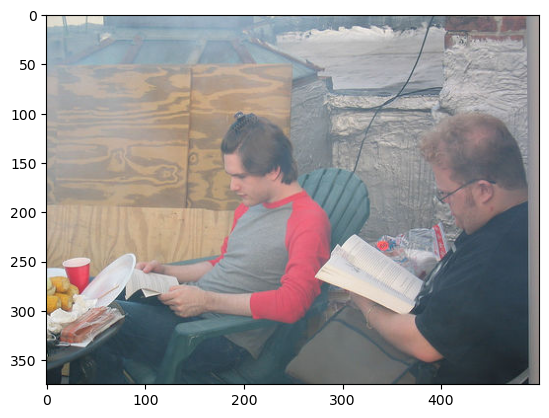

In [25]:
generate_caption("371903.jpg")

---------------------Actual---------------------
startseq group of friends playing cards and trying to bluff each other into making terrible mistake endseq
startseq group of college students gathers to play texas hold em poker endseq
startseq several men play cards while around green table endseq
startseq group of several men playing poker endseq
startseq six white males playing poker endseq
--------------------Predicted--------------------
startseq two men are sitting at table with beakers and alcohol endseq


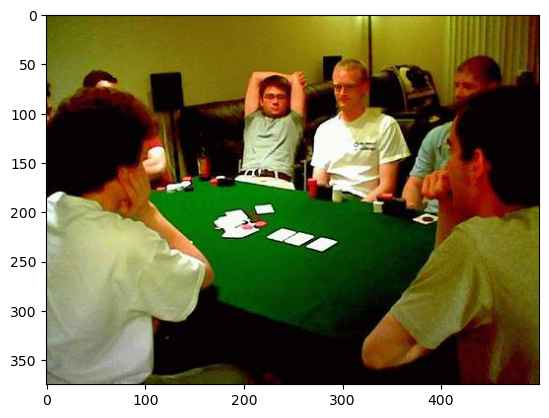

In [26]:
generate_caption("36979.jpg")

---------------------Actual---------------------
startseq dock workers helping each other straighten out ropes with bridge and ship in the background endseq
startseq group of people on bridge beside boat endseq
startseq three men draping rope across road endseq
startseq group of men are working on the docks endseq
startseq workers with ropes in the street endseq
--------------------Predicted--------------------
startseq man in black shirt and jeans is riding bike down the street endseq


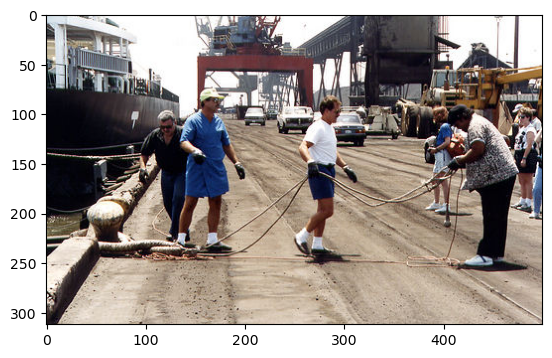

In [27]:
generate_caption("301246.jpg")

---------------------Actual---------------------
startseq skydiver hangs from the undercarriage of an airplane or some sort of air gliding device endseq
startseq person is hanging on to the bottom of an airplane preparing to skydive endseq
startseq person flying in air wearing sandals goggles and wind suit ." endseq
startseq someone is hanging on to plane high up in the air endseq
startseq here is stuntman hanging from helicopter endseq
--------------------Predicted--------------------
startseq man is parasailing on the beach endseq


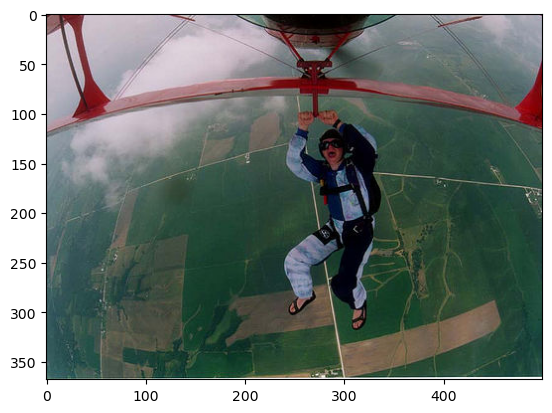

In [30]:
generate_caption("726414.jpg")

---------------------Actual---------------------
startseq the martial artist in white seems to have the upper hand on his older opponent endseq
startseq two men dressed in white uniforms one with black pants are doing karate ." endseq
startseq two men wearing martial arts clothing are practicing martial arts endseq
startseq two men are engaged in karate in an all white room endseq
startseq two martial artists practice in vacant room endseq
--------------------Predicted--------------------
startseq woman in white dress is dancing endseq


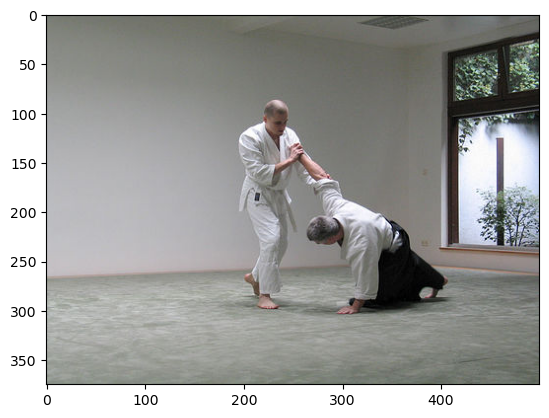

In [29]:
generate_caption("675153.jpg")

จากภาพทั้งหมดที่โมเดลได้ทำนายพบว่าโมเดลสามารถจับ Feature หรือข้อมูลบางอย่างมาทำ Caption ได้แต่ส่วนใหญ่มักจะเป็นแค่ บุคคล หรือสีของชุดที่สวมใส่ภายในภาพ ยังไม่สามารถอธิบายได้อย่างแน่ชัดว่าบุคคลในภาพกำลังทำหรือกำลังเกิดอะไรขึ้นได้อย่างถูกต้อง